In [161]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
import pandas as pd

from sklearn.datasets import load_iris, load_wine

import lib.util as util

from lib.eval.eval_metrics import *

from mmd_critic import MMDCritic
from mmd_critic.kernels import RBFKernel

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


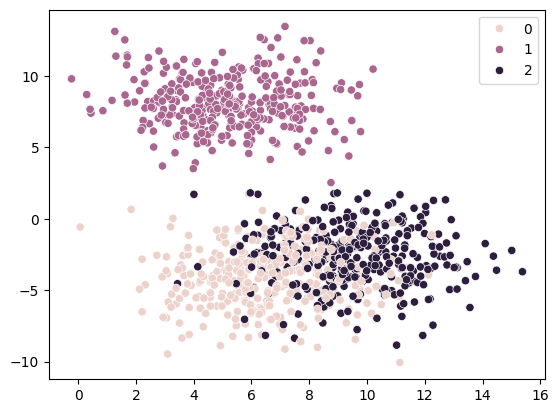

In [162]:
n = 1000
k = 3

X, y = make_blobs(centers=k, cluster_std=2, n_features=2, n_samples=n)
# eX = PCA(n_components=2).fit_transform(X)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.show()

/tmp/ipykernel_9/2642177044.py:9: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(criticisms[:, 0], criticisms[:, 1], c='red', s=100, edgecolor='r', marker='x', label='Criticisms')


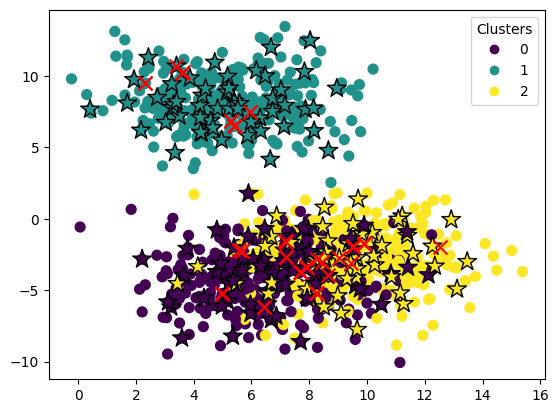

In [163]:
critic = MMDCritic(X, RBFKernel(sigma=1), criticism_kernel=RBFKernel(0.025), labels=y)

protos, proto_labels = critic.select_prototypes(int(n * 0.16))
criticisms, criticism_labels = critic.select_criticisms(int(n*0.04), protos)

# plot data with prototypes and criticisms
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', label='Data')
plt.scatter(protos[:, 0], protos[:, 1], c=proto_labels, s=200, edgecolor='k', marker='*', label='Prototypes')
plt.scatter(criticisms[:, 0], criticisms[:, 1], c='red', s=100, edgecolor='r', marker='x', label='Criticisms')
plt.legend()
# Add legend for cluster labels
handles, labels = scatter.legend_elements(prop="colors")
plt.legend(handles, labels, title="Clusters")
plt.show()

In [164]:
stc_X = np.concatenate([protos, criticisms], axis=0)
stc_y = np.concatenate([proto_labels, criticism_labels], axis=0)

unlabeled_indices = np.random.rand(stc_y.shape[0]) < 0.3
stc_y[unlabeled_indices] = -1

score: 0.832
target probability: [[0.04 0.04 0.92]]


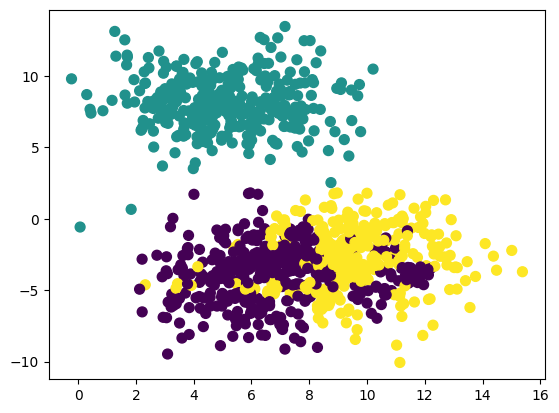

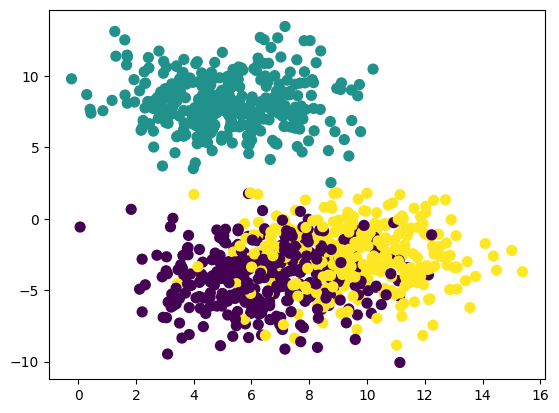

In [165]:
etc = ExtraTreesClassifier()
stc = SelfTrainingClassifier(etc)
stc.fit(stc_X, stc_y)
stc_y_pred = stc.predict(X)

print(f"score: {stc.score(X, y)}")
print(f"target probability: {stc.predict_proba(X[[0]])}")
plt.scatter(X[:, 0], X[:, 1], c=stc_y_pred, s=50, cmap='viridis', label='Data')
plt.show()
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', label='Data')
plt.show()